# k-means with text data

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

## Import necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

%matplotlib inline


## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
def load_sparse_csr(filename):
    loader=np.load(filename)
    data=loader['data']
    indices=loader['indices']
    indptr=loader['indptr']
    shape=loader['shape']
    
    return csr_matrix((data, indices, indptr),shape)

In [4]:
tf_idf=load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word=pd.read_json('people_wiki_map_index_to_word.json',typ='series')

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [5]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [6]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [7]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [8]:
# Students should write code here
queries=tf_idf[0:3]

distances=pairwise_distances(tf_idf, queries, metric='euclidean')
dist = pairwise_distances(tf_idf[430: 431],queries[1],metric='euclidean')
print dist

[[ 1.40713107]]


In [11]:
distances

array([[ 0.        ,  1.40775177,  1.38784582],
       [ 1.40775177,  0.        ,  1.39867641],
       [ 1.38784582,  1.39867641,  0.        ],
       ..., 
       [ 1.37070999,  1.40978937,  1.40616385],
       [ 1.35214578,  1.41306211,  1.40869799],
       [ 1.40799024,  1.41353429,  1.40903605]])

In [12]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [13]:
# Students should write code here
closest_cluster=np.argmin(distances, axis=1)
closest_cluster

array([0, 1, 2, ..., 0, 0, 0])

In [14]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [57]:
centroids=tf_idf[0:3,:]
distances=pairwise_distances(tf_idf, centroids)
distances
len(distances)
distances[100]
np.argmin(distances[100])

2

In [15]:
centroids=tf_idf[0:3,:]
distances=pairwise_distances(tf_idf, centroids)
distances

array([[ 0.        ,  1.40775177,  1.38784582],
       [ 1.40775177,  0.        ,  1.39867641],
       [ 1.38784582,  1.39867641,  0.        ],
       ..., 
       [ 1.37070999,  1.40978937,  1.40616385],
       [ 1.35214578,  1.41306211,  1.40869799],
       [ 1.40799024,  1.41353429,  1.40903605]])

In [16]:
len(distances)

59071

In [17]:
distances[100]
np.argmin(distances[100])

2

In [18]:
# Students should write code here
def arg(distances):
    cluster_assignment = list()
    for i in range(0,len(distances)):
        cluster_assignment.append(np.argmin(distances[i]))
    return np.array(cluster_assignment)
centroids = tf_idf[0:3,:]
distances = pairwise_distances(tf_idf,centroids)
cluster_assignment = arg(distances)

In [19]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [20]:
np.bincount(cluster_assignment)

array([23061, 10086, 25924])

In [21]:
sum(np.bincount(cluster_assignment))

59071

Now we are ready to fill in the blanks in this function:

In [22]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data,centroids)
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [23]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [24]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [25]:
cluster_assignment = assign_clusters(data, centroids)
print cluster_assignment

[0 1 0]


The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [26]:
cluster_assignment==1

array([False,  True, False], dtype=bool)

Likewise for cluster 0:

In [27]:
cluster_assignment==0

array([ True, False,  True], dtype=bool)

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [28]:
data[cluster_assignment==1]

array([[ 0.,  0.,  0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [29]:
data[cluster_assignment==0]

array([[ 1.,  2.,  0.],
       [ 2.,  2.,  0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [30]:
data[cluster_assignment==0].mean(axis=0)

array([ 1.5,  2. ,  0. ])

We are now ready to complete this function:

In [31]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [33]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))

In [34]:
result

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.50008938e-04,   8.46265596e-05,   2.38278645e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          8.72572638e-05,   6.98529765e-05,   1.99263190e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.01598466e-04,   8.08230804e-05,   1.77362711e-05]])

In [35]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [36]:
[centroids[1]]

[array([ 0. , -0.5,  0. ])]

In [53]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [54]:
data

array([[ 1.,  2.,  0.],
       [ 0.,  0.,  0.],
       [ 2.,  2.,  0.]])

In [55]:
data[cluster_assignment==1,:]

array([[ 0.,  0.,  0.]])

In [56]:
data[cluster_assignment==1]

array([[ 0.,  0.,  0.]])

In [57]:
[centroids[1]]

[array([ 0. , -0.5,  0. ])]

In [58]:
centroids

array([[ 0.5,  0.5,  0. ],
       [ 0. , -0.5,  0. ]])

In [59]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [63]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data,k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [64]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

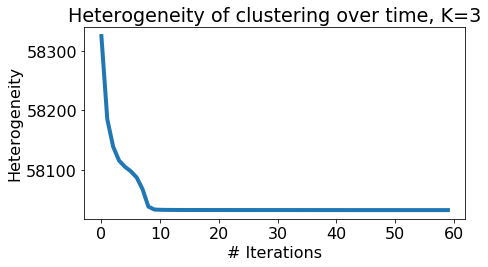

In [65]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

**Quiz Question**. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.

True.

**Quiz Question**. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

1

1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.

**Quiz Question**. Which of the cluster contains the greatest number of data points in the end? Hint: Use [`np.bincount()`](http://docs.scipy.org/doc/numpy-1.11.0/reference/generated/numpy.bincount.html) to count occurrences of each cluster label.

2
 1. Cluster #0
 2. Cluster #1
 3. Cluster #2

In [66]:
np.bincount(cluster_assignment)

array([19595, 10427, 29049])

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [67]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    print max(np.bincount(cluster_assignment))
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

18047
seed=000000, heterogeneity=57457.52442
15779
seed=020000, heterogeneity=57533.20100
18132
seed=040000, heterogeneity=57512.69257
17900
seed=060000, heterogeneity=57466.97925
17582
seed=080000, heterogeneity=57494.92990
16969
seed=100000, heterogeneity=57484.42210
16481
seed=120000, heterogeneity=57554.62410
365.648550034


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Quiz Question**. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?

15779     18132



One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [69]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from other centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [70]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
440.201977015


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

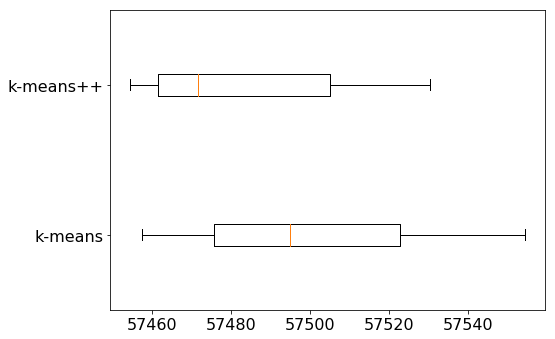

In [71]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [72]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data,k,seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroid, maxiter, heterogeneity, 
                                              verbose)
        
        # To save time, compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about one hour to finish. We highly suggest that you use the arrays that we have computed for you.**

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [94]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

To use the pre-computed NumPy arrays, first download kmeans-arrays.npz as mentioned in the reading for this assignment and load them with the following code.  Make sure the downloaded file is in the same directory as this notebook.

2
10
25
50
100


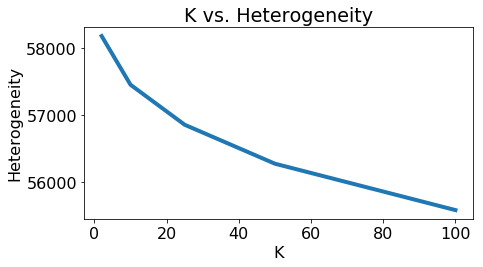

In [108]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        '''To save memory space, do not load the arrays from the file right away. We use
           a technique known as lazy evaluation, where some expressions are not evaluated
           until later. Any expression appearing inside a lambda function doesn't get
           evaluated until the function is called.
           Lazy evaluation is extremely important in memory-constrained setting, such as
           an Amazon EC2 t2.micro instance.'''
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [109]:
centroids

{2: <function __main__.<lambda>>,
 10: <function __main__.<lambda>>,
 25: <function __main__.<lambda>>,
 50: <function __main__.<lambda>>,
 100: <function __main__.<lambda>>}

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [110]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word.index[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

In [122]:
centroids[2]()

array([[  3.00882137e-06,   0.00000000e+00,   2.88868244e-06, ...,
          1.10291526e-04,   9.00609890e-05,   2.03703564e-05],
       [  0.00000000e+00,   8.57526623e-06,   0.00000000e+00, ...,
          1.38560691e-04,   6.46049863e-05,   2.26551103e-05]])

In [123]:
cluster_assignment[2]()

array([1, 0, 0, ..., 1, 1, 0])

In [112]:
'''Notice the extra pairs of parentheses for centroids and cluster_assignment.
   The centroid and cluster_assignment are still inside the npz file,
   and we need to explicitly indicate when to load them into memory.'''
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0     zwolsman:0.025 zx10r:0.017 zwigoff:0.012 zyuganovs:0.011 zyntherius:0.011 

* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda         

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: artists, songwriters, professors, politicians, writers, etc.
* Cluster 1: baseball players, hockey players, soccer (association football) players, etc.

Top words of cluster 1 are all related to sports, whereas top words of cluster 0 show no clear pattern.

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-atheletes into more categories. So let us use more clusters. How about `K=10`?

In [113]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0     zwacksalles:0.020 zuppiger:0.014 zyuganovs:0.011 zwangssterilisation:0.010 zwany:0.010 

* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0


* Todd Curley                                        0.92731
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Ashley Prescott                                    0.92992
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Pete Richardson                                    0.93204
  pete richardson born october 17 1946 in youngstown ohio is a former american football defe
  nsive back in the national football league and former college head

* Nathan Brown (Australian footballer born 1976)     0.93561
  nathan daniel brown born 14 august 1976 is an australian rules footballer who played for t
  he melbourne demons in the australian football leaguehe was drafted

* Earl Spalding                                      0.93654
  earl spalding born 11 march 1965 in sou

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, actors, film directors, playwrights
* Cluster 1: soccer (association football) players, rugby players
* Cluster 2: track and field athletes
* Cluster 3: baseball players
* Cluster 4: professors, researchers, scholars
* Cluster 5: Austrailian rules football players, American football players
* Cluster 6: female figures from various fields
* Cluster 7: composers, songwriters, singers, music producers
* Cluster 8: ice hockey players
* Cluster 9: politicians

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [114]:
np.bincount(cluster_assignment[10]())

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,  8926])

In [115]:
np.bincount(cluster_assignment[10]())[9]

8926

In [116]:
max(np.bincount(cluster_assignment[10]()))

17602

In [117]:
min(np.bincount(cluster_assignment[10]()))

599

In [118]:
for i in range(0,10):
    if np.bincount(cluster_assignment[10]())[i]==17602:
        print i

0


**Quiz Question**. Which of the 10 clusters above contains the greatest number of articles?

1. Cluster 0: artists, actors, film directors, playwrights
2. Cluster 4: professors, researchers, scholars
3. Cluster 5: Austrailian rules football players, American football players
4. Cluster 7: composers, songwriters, singers, music producers
5. Cluster 9: politicians

**Quiz Question**. Which of the 10 clusters contains the least number of articles?

1. Cluster 1: soccer (association football) players, rugby players
2. Cluster 3: baseball players
3. Cluster 6: female figures from various fields
4. Cluster 7: composers, songwriters, singers, music producers
5. Cluster 8: ice hockey players

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [119]:
visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0     zupan:0.077 zuddas:0.048 zts:0.046 zmajeviin:0.038 zombiethriller:0.038 
Cluster 1     zvezdy:0.054 zwane:0.033 zurichsalient:0.032 zyntherius:0.031 zhilabila:0.029 
Cluster 2     zhiyuan:0.216 zaruri:0.134 ziadahs:0.065 zwerge:0.052 zvuku:0.047 
Cluster 3     zurichminds:0.065 zumadespite:0.042 zuzana:0.031 zongon:0.027 zymans:0.023 
Cluster 4     zvakadaro:0.025 zwicky:0.023 zuleta:0.022 zurichandrey:0.022 zuni:0.020 
Cluster 5     zuffelato:0.160 zolile:0.056 zinmankillick:0.044 zurichminds:0.043 zumadespite:0.042 
Cluster 6     zyntherius:0.044 zwane:0.037 zurichsince:0.035 zvl:0.034 zmirs:0.031 
Cluster 7     zumadespite:0.066 yzfr7:0.058 zisman:0.051 zurichminds:0.045 zerounian:0.043 
Cluster 8     zimmermann:0.095 zagatcorson:0.056 zululand:0.054 zoobmg:0.052 yesno:0.051 
Cluster 9     zoheb:0.146 zoolander:0.096 zdorov:0.053 zow:0.048 zvezdy:0.043 
Cluster 10     zowie:0.075 zolecki:0.050 zadran:0.048 zealandamerican:0.048 zwolsman:0.048 
Cluster 11     zwolsman:0

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: **lawyers, judges, legal scholars**
* Cluster 1: **professors, researchers, scholars (natural and health sciences)**
* Cluster 2: ice hockey players
* Cluster 3: politicans
* Cluster 4: **government officials**
* Cluster 5: politicans
* Cluster 6: **professors, researchers, scholars (social sciences and humanities)**
* Cluster 7: Canadian politicians
* Cluster 8: **car racers**
* Cluster 9: **economists**
* Cluster 10: track and field athletes
* Cluster 11: females from various fields
* Cluster 12: (mixed; no clear theme)
* Cluster 13: baseball players
* Cluster 14: **painters, sculptors, artists**
* Cluster 15: Austrailian rules football players, American football players
* Cluster 16: **musicians, composers**
* Cluster 17: soccer (association football) players, rugby players
* Cluster 18: **poets**
* Cluster 19: **film directors, playwrights**
* Cluster 20: **songwriters, singers, music producers**
* Cluster 21: **generals of U.S. Air Force**
* Cluster 22: **music directors, conductors**
* Cluster 23: **basketball players**
* Cluster 24: **golf players**

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [120]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0     zaroori:0.137 zhaos:0.082 zurichhe:0.056 zaiku:0.053 yurkovich:0.050 
Cluster 1     zells:0.170 youthwing:0.085 yuenron:0.083 zombieadams:0.072 zealandnicholas:0.058 
Cluster 2     zingzillas:0.247 zynk:0.069 yrsa:0.056 yorkcross:0.031 yaounde:0.029 
Cluster 3     yurchenko:0.181 zen3:0.121 yox:0.042 zedek:0.036 zwangssterilisation:0.034 
Cluster 4     zappa:0.309 zaheer:0.220 yigal:0.066 zarrella:0.041 wollesen:0.031 
Cluster 5     zori:0.192 zurichreally:0.127 zero1:0.054 zvika:0.046 zubr:0.042 
Cluster 6     zombiethriller:0.059 zuddas:0.053 zubieta:0.051 zunnit:0.049 zwinger:0.044 
Cluster 7     zheleznyak:0.105 zubaydah:0.099 zisman:0.071 zumadespite:0.067 zoppis:0.061 
Cluster 8     zoheb:0.065 zyntherius:0.048 zvezdy:0.045 zwane:0.043 zoolander:0.043 
Cluster 9     zorbain:0.086 zilbers:0.076 zsi:0.061 zonderling:0.053 zwozdesky:0.040 
Cluster 10     zwolsman:0.188 zx10r:0.052 zouaoui:0.026 zoloft:0.020 zurita:0.019 
Cluster 11     yakko:0.246 wendlinger:0.097 wush

Cluster 61     zhi:0.193 yearkristock:0.132 ziauddin:0.052 zaimovzaimov:0.038 you:0.032 
Cluster 62     zapiski:0.362 znith:0.109 zealandtongan:0.084 zwolsman:0.057 yatchman:0.044 
Cluster 63     zhiyuan:0.220 zaruri:0.138 ziadahs:0.067 zwerge:0.053 zvuku:0.048 
Cluster 64     zupan:0.148 zts:0.093 zoku:0.071 zuddas:0.051 zoneplex:0.043 
Cluster 65     zuidams:0.205 zunr:0.086 ziza:0.059 zire:0.052 zumars:0.046 
Cluster 66     years100:0.278 wwwnaturebridgeorg:0.168 woodcuts:0.100 troyon:0.055 yearsit:0.031 
Cluster 67     zupanprofessor:0.088 zwanenburg:0.044 zwigoff:0.040 zuken:0.033 zpdas:0.027 
Cluster 68     zwolsman:0.158 zx10r:0.152 zwigoff:0.020 zupanprofessor:0.016 zucko:0.013 
Cluster 69     zrichprofessor:0.194 zsuzsa:0.034 zuffar:0.031 zuska:0.029 zsa:0.027 
Cluster 70     zrichin:0.099 zondag:0.089 zinkin:0.086 zvezdy:0.039 zaubersee:0.039 
Cluster 71     zulm:0.145 zongon:0.115 zurichminds:0.053 zymans:0.049 zunnit:0.048 
Cluster 72     zadran:0.459 zolzer:0.087 zwolsman:

The class of soccer (association football) players has been broken into two clusters (44 and 45). Same goes for Austrialian rules football players (clusters 26 and 48). The class of baseball players have been also broken into two clusters (16 and 91).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

**Quiz Question**. Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?

Hint: Use `cluster_assignment[100]()`, with the extra pair of parentheses for delayed loading.

In [121]:
cluster_size=np.bincount(cluster_assignment[100]())
count=0
for i in cluster_size:
    if i<236:
        count+=1
count

29

### Takeaway

Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may cause overfitting by reading too much into a limited pool of training data.